Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель**: Построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
#импортируем нужные библиотеки

from tensorflow.keras.preprocessing.image import ImageDataGenerator #инструмент создания пакетов данных изображений
from tensorflow.keras import Sequential                             #последовательная модель подходит для стека слоев, где каждый слой имеет ровно один входной тензор и один выходной тензор.
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense   #инструмент "усреднения" изображения и добавление "слоев" нейронной сети
from tensorflow.keras.optimizers import Adam                        #оптимизатор, основанный на метод стохастического градиентного спуска
from tensorflow.keras.applications.resnet import ResNet50           #предобученная нейросеть     


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
#загрузим описания признаков (номера фото) и таргет (возраст)

labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
#выведем статистику по датафрейму

def data_description(dataframe):
    print('\033[1m' "Общий вид данных" '\033[0m')
    print(dataframe.head())
    print()
    print('\033[1m' "Общая информация о датафрейме и типе данных" '\033[0m')
    print(dataframe.info())
    print()
    print('\033[1m' "Описание данных в столбцах датафрейма" '\033[0m')
    print(round(dataframe.describe(),2))
    print()
    print('\033[1m' "Количество пропусков" '\033[0m')
    print(dataframe.isna().sum())
    print()
    print('\033[1m' "Количество дубликатов" '\033[0m')
    print(dataframe.duplicated().sum())
    print()
    print('\033[1m' "Количество дубликатов в %" '\033[0m')
    print(dataframe.duplicated().sum()/dataframe.shape[0]*100)

In [4]:
data_description(labels)

Общий вид данных
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

Общая информация о датафрейме и типе данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None

Описание данных в столбцах датафрейма
       real_age
count   7591.00
mean      31.20
std       17.15
min        1.00
25%       20.00
50%       29.00
75%       41.00
max      100.00

Количество пропусков
file_name    0
real_age     0
dtype: int64

Количество дубликатов
0

Количество дубликатов в %
0.0


**Вывод**: Всего 7591 фотография, где представлены люди с возрастом от 1 до 100 лет.

**Вывод**: На первый взгляд объектов достаточно для обучения базовой модели, которая может быть дообучена в дальнейшем с поступлением новых фото по результатам разметки.

В тоже время, принимая во внимание факт, что выборка должна быть разделена на обучающую и валидационную, то количество фотографий можно увеличить. Особенно это может быть критичных на переходе возраста 18 лет, когда продажа алкоголя разрешена. Это одна из целей, установленных заказчиком, а значит надо внимательнее посмотреть, какое распределение по количеству фото имеет та или иная возрастная группа.

Кроме того количество фотографий можно увеличить "искуственно", применив вертикальное отображение, сдвиг при аугментации.

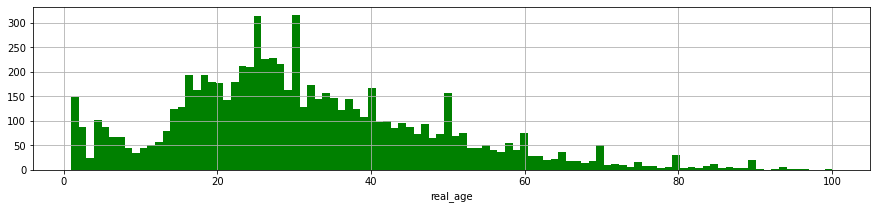

In [5]:
#Выведем гистограмму распределения возраста

labels['real_age'].hist(
            bins=100,
            grid=True,
            figsize=(15,3),
            color='green').set_xlabel('real_age')
plt.show()

**Вывод**: Принимая во внимание, что по краям гистограммы нормального распределения данных для обучения модели может быть недостаточно, модель может плохо предсказывать возраст людей в районе 10 лет и старше 60. Всплески в 25-30-40-50-60-70-80-90 лет похоже связаны с округлениями при разметке или сознательное увеличение выборок на "юбилейных" датах, чтобы легче отличать 30-летних от 40-летних и предлагать разные продуктовые корзины.

In [6]:
#сформируем загрузчик данных (частями) в виде фотографий для обучения модели

datagen_raw = ImageDataGenerator(rescale=1./255)

datagen_flow_raw = datagen_raw.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [7]:
#посмотрим характеристики сформированного загрузчика

datagen_flow_raw[0][0].shape

(32, 224, 224, 3)

**Вывод**: В одном наборе (батче) 32 цветные фотографии (3 слоя) размера 224х224. Всего 237 батчей для 7951 фото.

In [8]:
#посмотрим признаки и таргеты отдельно

features, target = next(datagen_flow_raw)

In [9]:
#таргеты - возраст людей 

target

array([ 4, 70, 39, 24, 41, 24, 16, 19, 38, 24, 41, 48, 23, 30, 29, 58, 30,
       31,  5, 23, 20, 43, 49, 32, 40, 14, 19, 31, 17, 29, 26, 14])

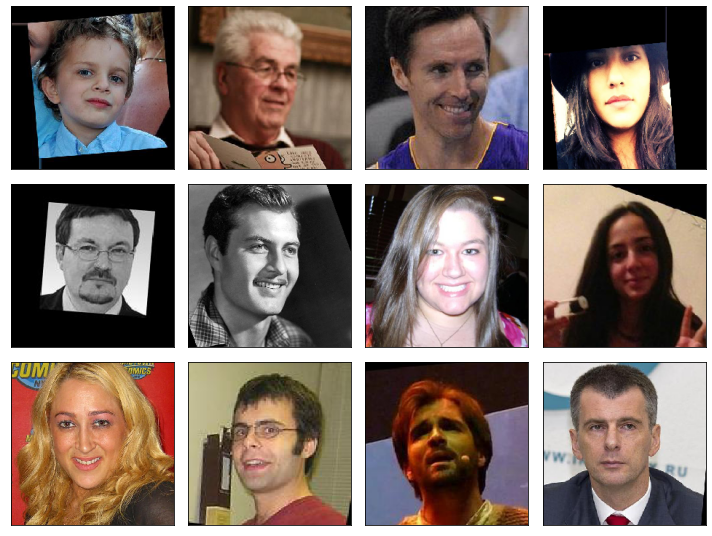

In [10]:
# выводим первые 12 изображений из признаков

fig = plt.figure(figsize=(10,10))
for i in range(0,12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Выводы**:

1.	Изображения представлены крупными фотографиями лиц по центру в повседневной обстановке, изображения цветные и черно-белые. Часть фото были обрезаны и повернуты так, чтобы линия глаз была горизонтальна, что говорит о предобработке фото.
2.	Количество фотографий для первоначального анализа достаточно, однако рекомендуется увеличить выборку на границе 18 лет и младше для более точной оценки возраста моделью, где "цена ошибки" может быть велика.
3.	Возраст имеет разбег от 1 года до 100 лет, отмечаются пики по количеству фотографий для возрастов 25-30-40-50-60-70-80-90 лет, что может быть связано с некачественной разметкой или сознательным увеличением выборки, чтобы легче отличать 30-летних от 40-летних и предлагать разные продуктовые корзины.
4.	Для искусственного увеличения выборки может быть рекомендовано зеркальное отображение фото относительно вертикальной оси и смещение фото на небольшой процент (до 20%), чтобы лица все еще были в центре.

## Обучение модели

```
#загрузка требуемых моделей


def load_train(path):
    
    labels = pd.read_csv('/datasets/faces/labels.csv')
    
    train_datagen = ImageDataGenerator(rescale=1./255,              #перевод значений пикселей к масштабу от 1 до 0
                                       validation_split=0.25,       #деление выборки на 25% для теста/валидации
                                       vertical_flip=True)          #некоторые фото могут быть отражены относительно вертикали

    train_gen_flow = train_datagen.flow_from_dataframe(             #создание загрузчика для обучающей фото-выборки 
        dataframe=labels,                                           #датафрейм csv файл с фозрастом и номером фото
        directory='/datasets/faces/final_files/',                   #фото берутся из папки по указанному пути
        x_col='file_name',                                          #признаки - фото
        y_col='real_age',                                           #таргет - возраст
        target_size=(224, 224),                                     #размеры фото для обучения
        batch_size=32,                                              #32 фото за раз в пуле для обучения
        class_mode='raw',                                           
        subset='training',                                          #обучающая выборка
        seed=12345)                                                 #показатель рандома
    
    return train_gen_flow

def load_test(path):
    
    labels = pd.read_csv('/datasets/faces/labels.csv')

    test_datagen = ImageDataGenerator(rescale=1./255,
                                      validation_split=0.25)

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    
    return test_gen_flow     

    
def create_model(input_shape):
    
    optimizer = Adam(lr=0.0001)                                     #оптимизатор Adam
    
    backbone = ResNet50(input_shape=input_shape,      
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)                              #предобученная на ImageNet сеть (база)

    model = Sequential()                                            #НС последовательная                              
    model.add(backbone)                                             #добавление "базы" ResNet50
              
    model.add(GlobalAveragePooling2D())                             #пулинг с окном во весь тензор, чтобы усреднить информацию                                                                     #по всему изображению, получить пиксель
                                                                    #с большим количеством каналов             
            
    model.add(Dense(512, activation='relu'))                        #слой с 512 нейронами
    
    model.add(Dense(512, activation='relu'))                        #слой с 512 нейронами
          
    model.add(Dense(1, activation='relu'))                          #вывод 1 нейрона с числовым предсказанием
    
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])
                                                                    #сборка модели с целевым показателем "MAE"
    
    return model   
    

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    
    train_gen_flow = train_data
    test_gen_flow = test_data
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    
    return model

```

## Результаты работы модели нейронных сетей:

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps
- Epoch 1/5
78/178 - 72s - loss: 10.5372 - mae: 10.5381 - val_loss: 15.8586 - val_mae: 15.8387

- Epoch 2/5
178/178 - 39s - loss: 7.0221 - mae: 7.0225 - val_loss: 13.7239 - val_mae: 13.6862

- Epoch 3/5
178/178 - 39s - loss: 6.0711 - mae: 6.0717 - val_loss: 13.1071 - val_mae: 13.0582

- Epoch 4/5
178/178 - 39s - loss: 5.3203 - mae: 5.3203 - val_loss: 7.9950 - val_mae: 7.9823

- Epoch 5/5
178/178 - 39s - loss: 4.8285 - mae: 4.8287 - val_loss: 6.7821 - val_mae: 6.7847

60/60 - 9s - loss: 6.7821 - mae: 6.7847
Test MAE: 6.7847

```

In [19]:
data_summary = {
                'loss': [10.5372, 7.0221, 6.0711, 5.3203, 4.8285],
                'MAE': [10.5381, 7.0225, 6.0717, 5.3203, 4.8287],
                'val_loss': [15.8586, 13.7239, 13.1071, 7.9950, 6.7821],
                'val_MAE': [15.8387, 13.6862, 13.0582, 7.9823, 6.7847]
                }

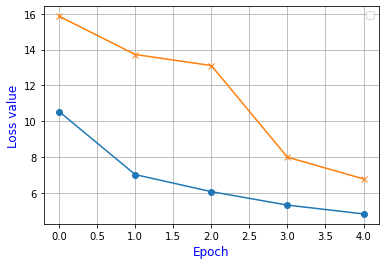

In [34]:
plt.xlabel('Epoch', fontsize=12, color='blue')
plt.ylabel('Loss value', fontsize=12, color='blue')
plt.grid(True)
plt.legend(["train","test"])
plt.plot(
    data_summary['loss'], 'o-',
    data_summary['val_loss'], 'x-',
)
plt.show()

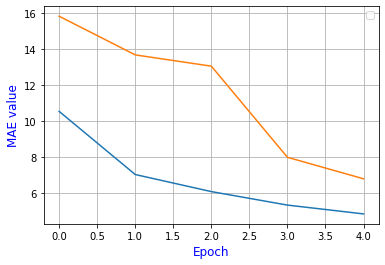

In [39]:
plt.xlabel('Epoch', fontsize=12, color='blue')
plt.ylabel('MAE value', fontsize=12, color='blue')
plt.grid(True)
plt.legend(["train","test"])
plt.plot(
    data_summary['MAE'], '-',
    data_summary['val_MAE'], '-',
)

## Анализ обученной модели

Целевой показатель `mean_absolute_error` меньше 8 был достигнут и равен 6.79 для модели:
- Архитектура ResNet50 на предобученной модели.
- Оптимизатор Adam(lr=0.0001), который дает результат быстрее градиентного бустинга -'sgd'
- Спосок активации 'relu' для решения задачи регрессии, когда требуется найти прогноз значения переменной.
- Применено 3 слоя в 512 / 512 / 1 нейрон
    - Применение слоев Dropout(0.8) не дало результата, (0.5) - улучшило незначительно

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы